In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.gen = nn.Sequential(
          nn.Linear(100,256),
          nn.LeakyReLU(0.2),
          nn.Linear(256,512),
          nn.LeakyReLU(0.2),
          nn.Linear(512,1024),
          nn.LeakyReLU(0.2),
          nn.Linear(1024,28*28),
          nn.Tanh(),
      )
  def forward(self,x):
    x = self.gen(x)
    return x.view(-1,1,28,28)

In [3]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.dis = nn.Sequential(
        nn.Linear(28*28,1024),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(1024,512),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(512,256),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),
        nn.Linear(256,1),
        nn.Sigmoid()      
    )
  def forward(self,x):
    return self.dis(x)

In [4]:
dataset = torchvision.datasets.MNIST(root='/content/',download=True,transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((.5,), (.5,))]))
dataloader = torch.utils.data.DataLoader(dataset=dataset,batch_size=100,shuffle=True)


Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw




Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw




Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw




Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
epochs = 50
lr = 1e-4
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 100

disc = Discriminator().to(device)
gen = Generator().to(device)

criterion = nn.BCELoss()
opt_disc = torch.optim.Adam(params=disc.parameters(),lr=lr)
opt_gen = torch.optim.Adam(params=gen.parameters(),lr=lr)

In [6]:
for epoch in range(0,epochs):
  for batch_index , (real_images,_) in enumerate(dataloader):
    real_images = real_images.to(device)
    real_images = real_images.view(-1,28*28)
    batch_size = real_images.shape[0]

    # Training the Discriminator
    noise = torch.randn(batch_size,100).to(device)
    fake_images = gen(noise)
    disc_real_images = disc(real_images).view(-1)
    loss_real_images = criterion(disc_real_images,torch.ones_like(disc_real_images))
    fake_images = fake_images.view(-1,28*28)
    disc_fake_images = disc(fake_images)
    loss_fake_images = criterion(disc_fake_images,torch.zeros_like(disc_fake_images))
    lossD = loss_real_images + loss_fake_images
    disc.zero_grad()
    lossD.backward(retain_graph=True)
    opt_disc.step()

    #Training the Generator
    result = disc(fake_images)
    lossG = criterion(result,torch.ones_like(result))
    gen.zero_grad()
    lossG.backward(retain_graph=True)
    opt_gen.step()
    if batch_index % 100 == 0:
      print(f"Epoch {epoch}/{epochs} Batch {batch_index}/{len(dataloader)} Loss D: {lossD:.4f}, loss G: {lossG:.4f}")

Epoch 0/50 Batch 0/600 Loss D: 1.3722, loss G: 0.7177
Epoch 0/50 Batch 100/600 Loss D: 0.7827, loss G: 0.9344
Epoch 0/50 Batch 200/600 Loss D: 1.6361, loss G: 0.8193
Epoch 0/50 Batch 300/600 Loss D: 0.4650, loss G: 2.0894
Epoch 0/50 Batch 400/600 Loss D: 0.5440, loss G: 2.8802
Epoch 0/50 Batch 500/600 Loss D: 0.5921, loss G: 2.5822
Epoch 1/50 Batch 0/600 Loss D: 0.6784, loss G: 2.6285
Epoch 1/50 Batch 100/600 Loss D: 1.6904, loss G: 0.9711
Epoch 1/50 Batch 200/600 Loss D: 1.7293, loss G: 0.7753
Epoch 1/50 Batch 300/600 Loss D: 0.7920, loss G: 1.8090
Epoch 1/50 Batch 400/600 Loss D: 1.1866, loss G: 0.9225
Epoch 1/50 Batch 500/600 Loss D: 0.9756, loss G: 1.1483
Epoch 2/50 Batch 0/600 Loss D: 0.6922, loss G: 1.3457
Epoch 2/50 Batch 100/600 Loss D: 0.6759, loss G: 1.9142
Epoch 2/50 Batch 200/600 Loss D: 0.5309, loss G: 2.4018
Epoch 2/50 Batch 300/600 Loss D: 0.1952, loss G: 3.7917
Epoch 2/50 Batch 400/600 Loss D: 0.3788, loss G: 3.2334
Epoch 2/50 Batch 500/600 Loss D: 0.4023, loss G: 4.105

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


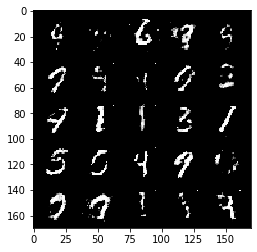

In [7]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

noise = torch.randn(25,100)
generated_images = gen(noise.to(device))
generated_images = generated_images.cpu()
grid = torchvision.utils.make_grid(generated_images, nrow=5,padding=5)
show(grid)